In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_csv('ratings.csv')

In [28]:
# Préparation des features basées sur MovieLens
# Agrégation par utilisateur pour créer des variables utiles
user_stats = df.groupby('userId').agg({
    'rating': ['count', 'mean'],  # Nombre de notations et moyenne des notes
    'timestamp': ['min', 'max']   # Plage temporelle d'activité
}).reset_index()

In [29]:
user_stats.columns = ['userId', 'nb_ratings', 'avg_rating', 'first_timestamp', 'last_timestamp']

In [30]:
# Calcul de la durée d'activité (en jours)
user_stats['activity_duration_days'] = (user_stats['last_timestamp'] - user_stats['first_timestamp']) / (60*60*24)

In [31]:
# Définition d'une cible : engagement (1 = engagé, 0 = non engagé)
user_stats['engagement'] = ((user_stats['nb_ratings'] > 50) & (user_stats['avg_rating'] > 3.5)).astype(int)

In [32]:
# Sélection des features pertinentes
features = ['nb_ratings', 'avg_rating', 'activity_duration_days']
X = user_stats[features]
y = user_stats['engagement']

# Exploration rapide des données
print("Aperçu des données :")
print(user_stats.head())
print("\nStatistiques descriptives :")
print(user_stats.describe())

Aperçu des données :
   userId  nb_ratings  avg_rating  first_timestamp  last_timestamp  \
0       1          27    4.277778       1425941300      1425942699   
1       2          22    3.318182        867039165       867041296   
2       3          10    3.100000       1048076830      1048077048   
3       4          62    3.500000       1042667845      1042674886   
4       5          26    4.269231        949423787       949424522   

   activity_duration_days  engagement  
0                0.016192           0  
1                0.024664           0  
2                0.002523           0  
3                0.081493           0  
4                0.008507           0  

Statistiques descriptives :
              userId     nb_ratings     avg_rating  first_timestamp  \
count  270896.000000  270896.000000  270896.000000     2.708960e+05   
mean   135448.500000      96.067454       3.620538     1.136934e+09   
std     78201.083599     205.719606       0.576122     2.181206e+08   
min  

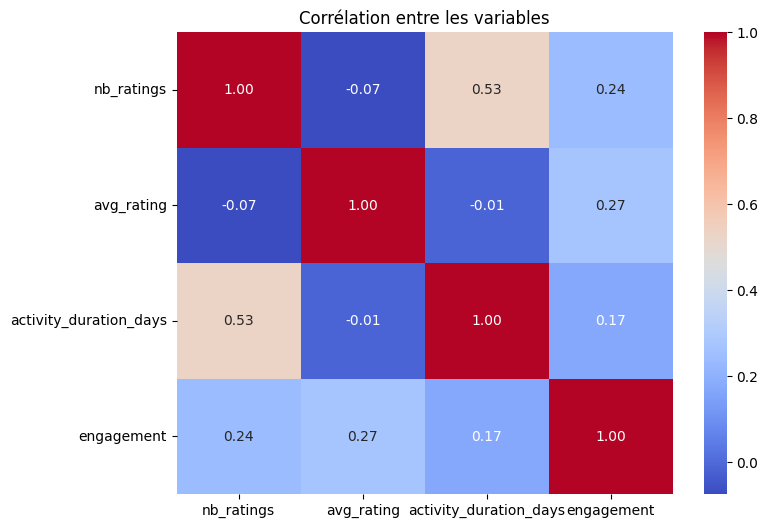

In [33]:
# Visualisation : Corrélation entre variables
plt.figure(figsize=(8, 6))
sns.heatmap(user_stats[features + ['engagement']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Corrélation entre les variables")
plt.show()

In [34]:
# Division en entraînement et test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement d’un modèle de classification (régression logistique)
model = LogisticRegression(max_iter=200, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=200)

In [35]:
# Prédictions
y_pred = model.predict(X_test)

In [36]:
# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrécision du modèle : {accuracy:.2f}")
print("\nRapport de classification :")

print(classification_report(y_test, y_pred))


Précision du modèle : 0.75

Rapport de classification :
              precision    recall  f1-score   support

           0       0.90      0.75      0.82     40917
           1       0.49      0.74      0.59     13263

    accuracy                           0.75     54180
   macro avg       0.69      0.75      0.70     54180
weighted avg       0.80      0.75      0.76     54180



y_test: [0 1]
y_pred: [1 1 1 ... 1 0 0]


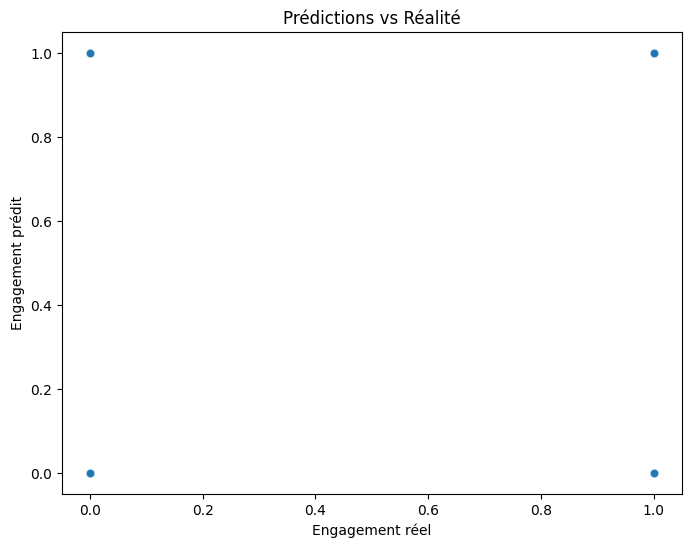

In [37]:
print("y_test:", y_test.unique())
print("y_pred:", y_pred)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Engagement réel")
plt.ylabel("Engagement prédit")
plt.title("Prédictions vs Réalité")
plt.show()

In [38]:
nouvel_utilisateur = np.array([[100, 4.0, 365]])  # 100 notations, moyenne 4.0, actif 1 an
pred_engagement = model.predict(nouvel_utilisateur)
print(f"Engagement prédit pour un nouvel utilisateur : {'Engagé' if pred_engagement[0] == 1 else 'Non engagé'}")

Engagement prédit pour un nouvel utilisateur : Engagé


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [39]:
from sklearn.model_selection import cross_val_score
# Effectuer une validation croisée à 5 plis
cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
print(f"Scores F1 par pli: {cv_scores}")
print(f"Score F1 moyen: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Scores F1 par pli: [0.58522255 0.59246832 0.59200525 0.59126254 0.59414251]
Score F1 moyen: 0.591 ± 0.003


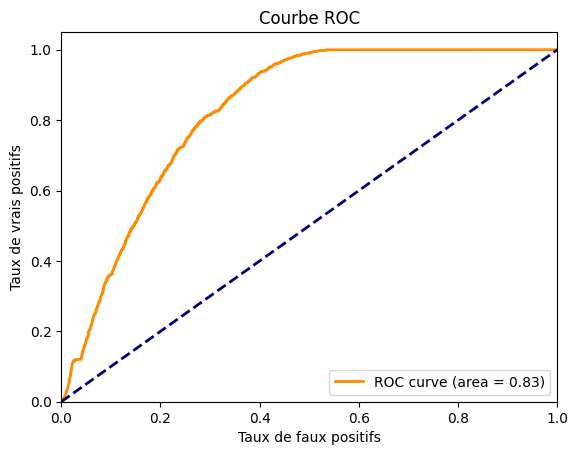

In [41]:
import matplotlib.pyplot as plt

# Prédire les probabilités
y_proba = model.predict_proba(X_test)[:, 1]

# Calculer et tracer la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

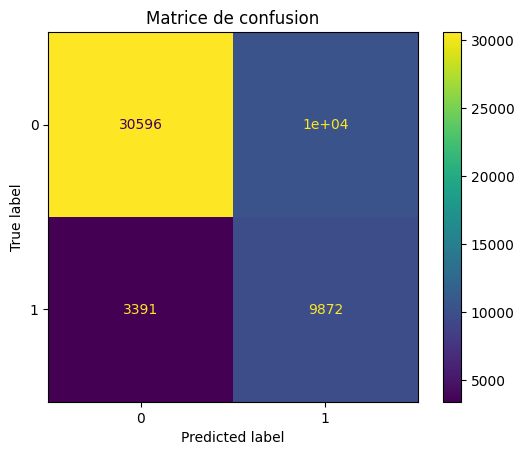

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Matrice de confusion')
plt.show()

In [43]:
# Tester le modèle avec différents profils d'utilisateurs
test_users = [
    [100, 4.0, 365],   # Beaucoup de ratings, bonne moyenne, actif depuis longtemps
    [20, 4.5, 30],     # Peu de ratings, excellente moyenne, nouveau
    [200, 3.0, 1000],  # Beaucoup de ratings, moyenne moyenne, très ancien
    [30, 3.0, 10],     # Peu de ratings, moyenne moyenne, très nouveau
    [50, 4.0, 100]     # À la limite de votre définition d'engagement
]

print("Prédictions pour différents profils d'utilisateurs:")
for i, user in enumerate(test_users):
    pred = model.predict(np.array([user]))
    proba = model.predict_proba(np.array([user]))[0][1]
    print(f"Utilisateur {i+1} {user}: {'Engagé' if pred[0] == 1 else 'Non engagé'} (Probabilité d'engagement: {proba:.2f})")

Prédictions pour différents profils d'utilisateurs:
Utilisateur 1 [100, 4.0, 365]: Engagé (Probabilité d'engagement: 0.62)
Utilisateur 2 [20, 4.5, 30]: Engagé (Probabilité d'engagement: 0.73)
Utilisateur 3 [200, 3.0, 1000]: Non engagé (Probabilité d'engagement: 0.29)
Utilisateur 4 [30, 3.0, 10]: Non engagé (Probabilité d'engagement: 0.11)
Utilisateur 5 [50, 4.0, 100]: Engagé (Probabilité d'engagement: 0.54)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist